# Triple Pendulum

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

In [2]:
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):

    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))


    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))


    g, t = symbols('g,t')
    

    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)


    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):

        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)


        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)


        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)


        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi


    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(forces, particles)
    
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        

    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)


    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)


    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()


    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)


    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)


    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]


    return odeint(gradient, y0, times, args=(parameter_vals,))

In [3]:
def get_xy_coords(p, lengths=None):

    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    
    return np.cumsum(x, 1), np.cumsum(y, 1)

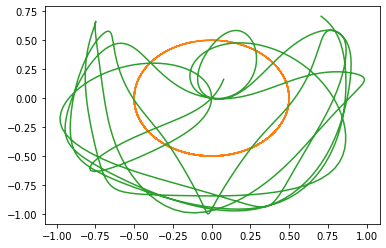

In [4]:
t = np.linspace(0, 10, 1000)
p = integrate_pendulum(n=2, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

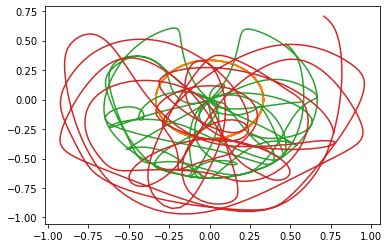

In [5]:
p = integrate_pendulum(n=3, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

In [6]:
from matplotlib import animation


def animate_pendulum(n):
    t = np.linspace(0, 10, 200)
    p = integrate_pendulum(n, t)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [7]:
anim = animate_pendulum(3)

In [8]:
from IPython.display import HTML
anim.save('Triple-Pendulum.mp4', extra_args=['-vcodec', 'libx264'])

In [9]:
anim = animate_pendulum(5)

In [10]:
anim.save('Quintuple-Pendulum.mp4', extra_args=['-vcodec', 'libx264'])

In [11]:
from matplotlib import collections


def animate_pendulum_multiple(n, n_pendulums=41, perturbation=1E-6, track_length=15):
    oversample = 3
    track_length *= oversample
    
    t = np.linspace(0, 10, oversample * 200)
    p = [integrate_pendulum(n, t, initial_positions=135 + i * perturbation / n_pendulums)
         for i in range(n_pendulums)]
    positions = np.array([get_xy_coords(pi) for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    track_segments = np.zeros((n_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow')
    tracks.set_array(np.linspace(0, 1, n_pendulums))
    ax.add_collection(tracks)
    
    points, = plt.plot([], [], 'ok')
    
    pendulum_segments = np.zeros((n_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((n_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((n_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim
    
anim = animate_pendulum_multiple(3)

In [12]:
anim.save('Triple-Pendulum-Chaos.mp4', extra_args=['-vcodec', 'libx264'])